funciona mejor

*   la extension de 1.2 aumenta el error de train porque evalua en regiones que no son adecuadas pero hace mejorar el de test que si se evalua donde corresponde
*   +30 epocas por muestra



In [ ]:

#%% import needed packages
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
tf.compat.v1.disable_eager_execution() #para ser compatibles con la versión1
import random
random.seed(0)


import plotly.graph_objects as go
import plotly.express as px
import scipy.special as sc
from matplotlib.animation import FuncAnimation


import warnings
warnings.filterwarnings("ignore")
import heapq

# Black Scholes 1D

 ### DGM 1D: funciones

In [ ]:
def error_train():
  # time values at which to examine density

  RMSE_i=[] #interior
  sup_i=0
  RMSE_f=[] #frontera
  sup_f=0

  for epoch in range(len(X_train)):
    #dominio
    optionValue = BlackScholesCall(X_train[epoch][1], K, r, sigma, X_train[epoch][0])
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
    RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
    
    dif= np.subtract(optionValue.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_i_=np.max(col)
    if sup_i<sup_i_:
      sup_i= sup_i_
      punto_sup_i=np.argmax(col)
      espacio_sup_i= X_train[epoch][1][punto_sup_i]
      tiempo_sup_i=X_train[epoch][0][punto_sup_i]

    #frontera
    optionValue = BlackScholesCall(X_train[epoch][3], K, r, sigma, X_train[epoch][2])
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
    RMSE_f.append(mean_squared_error(optionValue, fitted_optionValue[0]))

    dif= np.subtract(optionValue.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_f_=np.max(col)
    if sup_f<sup_f_:
      sup_f= sup_f_
      punto_sup_f=np.argmax(col)
      espacio_sup_f= X_train[epoch][3][punto_sup_f]
      
  print("L2")
  print(np.mean(RMSE_i))
  print(np.mean(RMSE_f))
  print("L inf")
  print(sup_i,"punto :",espacio_sup_i,tiempo_sup_i)
  print(sup_f, "punto :",espacio_sup_f, T)
  return RMSE_i,RMSE_f,sup_i,sup_f


def error_test():
  # time values at which to examine density
  n_eval= int(nSim_interior*len(X_train)*0.1) #10% test
  n_eval_t= 100
  valueTimes=np.linspace(t_low, T, n_eval_t)

  # vector of t and S values for plotting
  S_plot = np.linspace(S_low, S_high, n_eval)

  #RMSE

  RMSE_i_test=[] #interior
  sup_i=0
  c=0


  for curr_t in valueTimes:

  # simulate process at current t 
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
      
      # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    RMSE_i_test.append(mean_squared_error(optionValue, fitted_optionValue[0]))

    dif= np.subtract(optionValue.reshape(-1,1), fitted_optionValue[0]) 
    col= np.square(dif)
    sup_i_=np.max(col)
    if sup_i<sup_i_:
      sup_i= sup_i_
      punto_sup_i=np.argmax(col )
      tiempo_sup_i=curr_t
    if c==0:
      c+=1
      error_matrix= np.flip(col)
    else:
      error_matrix= np.concatenate((error_matrix, np.flip(col)),axis=1)

  #frontera

  optionValue = BlackScholesCall(S_plot, K, r, sigma, T)
    
  t_plot = T * np.ones_like(S_plot.reshape(-1,1))
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
  RMSE_f_test= mean_squared_error(optionValue, fitted_optionValue[0])

  dif= np.subtract(optionValue.reshape(-1,1), fitted_optionValue[0]) 
  col= np.square(dif)
  sup_f= np.max(col)
  punto_sup_f=np.argmax(col)
  error_matrix= np.concatenate((error_matrix, np.flip(col)),axis=1)

  print("L2")
  print(np.mean(RMSE_i_test) )
  print(RMSE_f_test)
  print("L inf")
  print(sup_i,"punto :",S_plot[punto_sup_i],tiempo_sup_i)
  print(sup_f, "punto :",S_plot[punto_sup_f] , T)
  return RMSE_i_test,RMSE_f_test,sup_i,sup_f,error_matrix

https://github.com/alialaradi/DeepGalerkinMethod

### Arquitectura

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD


#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x1):
        '''            
        Args:
            t: sampled time inputs 
            x: Lista sampled space inputs 

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        
        X = tf.concat([t,x1],1) #agregar mas variables 
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

#### otra

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD


#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)

        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # w vectors (weighting vectors for output of previous layer)        

        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = H
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x1):
        '''            
        Args:
            t: sampled time inputs 
            x: Lista sampled space inputs 

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        
        X = tf.concat([t,x1],1) #agregar mas variables 
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

### Setup de la ecuación

In [ ]:
#%% Parameters 
# Option parameters
r = 0.05           # Interest rate
sigma = 0.25       # Volatility
K = 50             # Strike
T = 1              # Terminal time
S0 = 0.5           # Initial price

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
#t_low = - 1e-10
S_low = 0.0 + 1e-10  # spot price lower bound
#S_low = -1e-10 
S_high = 2*K         # spot price upper bound

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 50   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 500
nSim_terminal = 100
S_multiplier  = 1.2   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

# Plot options
n_plot = 70  # Points on plot grid for each dimension

In [ ]:
#%% Black-Scholes European call price

def BlackScholesCall(S, K, r, sigma, t):
    ''' Analytical solution for European call option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t))/(sigma * np.sqrt(T-t))
    d2 = d1 - (sigma * np.sqrt(T-t))

    callPrice = S * spstats.norm.cdf(d1) - K * np.exp(-r * (T-t)) * spstats.norm.cdf(d2)
    
    return callPrice

### Muestreo

https://plotly.com/python/animations/

In [ ]:


#%% Sampling function - randomly sample time-space pairs 

def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 1])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal


In [ ]:
muestreo= pd.DataFrame(columns=["tiempo","precio","region","epoca"])
# for each sampling stage
c=0
for j in range(int(sampling_stages/4)):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)
    for i in range(int(nSim_interior/4)):
      muestreo.loc[c]= [t_interior[i][0], S_interior[i][0], "interior", j]
      c+=1
    for i in range(int(nSim_terminal/2)):
      muestreo.loc[c]= [t_terminal[i][0], S_terminal[i][0], "terminal", j]
      c+=1


KeyboardInterrupt: ignored

In [ ]:
px.scatter(muestreo, x="tiempo", y="precio", animation_frame="epoca", color="region",hover_name="region", range_x=[0,1], range_y=[0,150])

boxplot errores

**adabosting** 

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

catboost


In [ ]:
px.scatter(muestreo, x="tiempo", y="precio", range_x=[0,1], range_y=[0,150],color="region")

#### muestreo indep

Muestrear de manera independiente

tiene que considir las epocas con el tiempo...

In [ ]:
muestreo_indep= pd.DataFrame(columns=["tiempo","precio","region","epoca"])
# for each sampling stage
c=0
t_interior, S_interior, t_terminal, S_terminal = sampler(sampling_stages, sampling_stages)
for j in range(sampling_stages):
    for i in range(sampling_stages):
      muestreo_indep.loc[c]= [t_interior[j][0], S_interior[i][0], "interior", j]
      c+=1
      muestreo_indep.loc[c]= [t_terminal[j][0], S_terminal[i][0], "terminal", j]
      c+=1


In [ ]:
px.scatter(muestreo_indep, x="tiempo", y="precio", animation_frame="epoca", color="region",hover_name="region", range_x=[0,1], range_y=[0,150])

In [ ]:
px.scatter(muestreo_indep, x="tiempo", y="precio", range_x=[0,1], range_y=[0,150],color="region")

 #### adaptativo

In [ ]:
def sampler_adaptativo(nSim_interior, nSim_terminal, e_tiempo, e_espacio):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior


    if t_low+0.02<e_tiempo<T-0.02 and S_low+15<e_espacio<S_high-15 :

      t_interior_1 = np.random.uniform(low=t_low, high=T, size=[int(nSim_interior/2), 1])
      S_interior_1 = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[int(nSim_interior/2), 1])      
      #error
      t_interior_2= np.random.uniform(low=e_tiempo- 0.01, high=e_tiempo+0.01, size=[int(nSim_interior/2), 1])
      S_interior_2 = np.random.uniform(low=e_espacio -10, high=e_espacio+10, size=[int(nSim_interior/2), 1])

      t_interior= np.concatenate([t_interior_1,t_interior_2],axis=0)
      S_interior= np.concatenate([S_interior_1,S_interior_2],axis=0)

    else:
      t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
      S_interior = np.random.uniform(low=S_low, high=S_high, size=[nSim_interior, 1])
      #t_interior_1 = np.random.uniform(low=t_low, high=T, size=[int(nSim_interior/2), 1])
      #S_interior_1 = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[int(nSim_interior/2), 1])
      #t_interior_2= np.random.uniform(low= t_low, high=t_low+0.01, size=[int(nSim_interior/2), 1])
      #S_interior_2 = np.random.uniform(low= S_high-10, high=S_high, size=[int(nSim_interior/2), 1])
      #t_interior= np.concatenate([t_interior_1,t_interior_2],axis=0)
      #S_interior= np.concatenate([S_interior_1,S_interior_2],axis=0)    

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal

In [ ]:
muestreo= pd.DataFrame(columns=["tiempo","precio","region","epoca"])
# for each sampling stage
c=0
for j in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = X_train[j]
    for i in range(nSim_interior):
      muestreo.loc[c]= [t_interior[i][0], S_interior[i][0], "interior", j]
      c+=1
    for i in range(nSim_terminal):
      muestreo.loc[c]= [t_terminal[i][0], S_terminal[i][0], "terminal", j]
      c+=1


In [ ]:
px.scatter(muestreo, x="tiempo", y="precio", animation_frame="epoca", color="region",hover_name="region", range_x=[0,1], range_y=[0,120])

antes de 1.2 , ahora con 1

In [ ]:
muestreo= pd.DataFrame(columns=["tiempo","precio","region","epoca"])
# for each sampling stage
c=0
for j in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = X_train[j]
    for i in range(nSim_interior):
      muestreo.loc[c]= [t_interior[i][0], S_interior[i][0], "interior", j]
      c+=1
    for i in range(nSim_terminal):
      muestreo.loc[c]= [t_terminal[i][0], S_terminal[i][0], "terminal", j]
      c+=1


In [ ]:
px.scatter(muestreo, x="tiempo", y="precio", animation_frame="epoca", color="region",hover_name="region", range_x=[0,1], range_y=[0,110])

### Loss

In [ ]:

#%% Loss function for Fokker-Planck equation

def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    V = model(t_interior, S_interior)#quitar
    V_t = tf.gradients(ys=V, xs=t_interior)[0]
    V_s = tf.gradients(ys=V, xs=S_interior)[0]
    #V_y= tf.gradients(ys=V, xs=S_terminal)[0]
    #print("tengo la derivada")
    V_ss = tf.gradients(ys=V_s, xs=S_interior)[0]
    diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_ss + r * S_interior * V_s - r*V

    # compute average L2-norm of differential operator
    L1 = tf.reduce_mean(input_tensor=tf.square(diff_V)) 
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    
    # Loss term #3: initial/terminal condition
    target_payoff = tf.nn.relu(S_terminal - K)
    fitted_payoff = model(t_terminal, S_terminal)
    
    L3 = tf.reduce_mean( input_tensor=tf.square(fitted_payoff - target_payoff) )

    return tf.square(diff_V), tf.square(fitted_payoff - target_payoff)

### Entrenamiento

#### normal

In [ ]:
#Loss=[]
loss_por_batch=[]
X_train=[]
#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)#1

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr= loss(model, t_interior_tnsr, S_interior_tnsr, t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr = tf.reduce_mean(L1_tnsr) + tf.reduce_mean(L3_tnsr) 

# option value function
V = model(t_interior_tnsr, S_interior_tnsr)

# set optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.compat.v1.global_variables_initializer()

# open session
sess = tf.compat.v1.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    #t_interior, S_interior, t_terminal, S_terminal = sampler(int(nSim_interior*(i+1)/25), int(nSim_terminal*(i+1)/5)) #general particular

    t_interior, S_interior, t_terminal, S_terminal = sampler(int(nSim_interior), int(nSim_terminal)) #normal
    #t_= np.random.choice(np.linspace(0,1,50))
    #e_= np.random.choice(np.linspace(0,100,50))
    #t_interior, S_interior, t_terminal, S_terminal =sampler_adaptativo(nSim_interior, nSim_terminal, ( t_,t_+0.1 ) ,(e_,e_+10))
    X_train.append([t_interior, S_interior, t_terminal, S_terminal])
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L3,_= sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
        #Loss.append((loss,L1,L3))
    #print(loss, L1, L3, i)
    loss_por_batch.append((loss,np.mean(L1),np.mean(L3)))

In [ ]:
fig = go.Figure()

x=  list(range(sampling_stages))
loss =[i[0] for i in loss_por_batch]
L1= [i[1] for i in loss_por_batch]
L2= [i[2] for i in loss_por_batch]
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=loss,
                    mode='lines',
                    name='Loss'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L1,
                    mode='lines',
                    name='L: Interior'))

fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L2,
                    mode='lines',
                    name='L:Frontera'))
fig.update_layout(title='Pérdida por épocas',
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

#### adaptativo

In [ ]:
#Loss=[]
loss_por_batch=[]
X_train=[]
#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)#1

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
t_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.compat.v1.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr= loss(model, t_interior_tnsr, S_interior_tnsr, t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr = tf.reduce_mean(L1_tnsr) + tf.reduce_mean(L3_tnsr)

# option value function
V = model(t_interior_tnsr, S_interior_tnsr)

# set optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.compat.v1.global_variables_initializer()

# open session
sess = tf.compat.v1.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
c=0
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    #t_interior, S_interior, t_terminal, S_terminal = sampler(int(nSim_interior*(i+1)/25), int(nSim_terminal*(i+1)/5)) #general particular
    if c==0:
      c+=1
      t_interior, S_interior, t_terminal, S_terminal = sampler(int(nSim_interior), int(nSim_terminal)) #normal
      X_train.append([t_interior, S_interior, t_terminal, S_terminal])
    else:
      t_interior, S_interior, t_terminal, S_terminal = sampler_adaptativo(int(nSim_interior), int(nSim_terminal),e_t,S_t ) #normal
      X_train.append([t_interior, S_interior, t_terminal, S_terminal])
    
    #t_= np.random.choice(np.linspace(0,1,50))
    #e_= np.random.choice(np.linspace(0,100,50))
    #t_interior, S_interior, t_terminal, S_terminal =sampler_adaptativo(nSim_interior, nSim_terminal, ( t_,t_+0.1 ) ,(e_,e_+10))
   
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample+30):
        loss,L1,L3,_= sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
        #Loss.append((loss,L1,L3))
    #print(loss, L1, L3, i)
    loss_por_batch.append((loss,np.mean(L1),np.mean(L3)))

    ind= np.argmax(abs(L1 - np.mean(L1)))
    e_t= t_interior[ind][0]
    S_t= S_interior[ind][0]
    


NameError: ignored

In [ ]:
fig = go.Figure()

x=  list(range(sampling_stages))
loss =[i[0] for i in loss_por_batch]
L1= [i[1] for i in loss_por_batch]
L2= [i[2] for i in loss_por_batch]
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=loss,
                    mode='lines',
                    name='Loss'))
fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L1,
                    mode='lines',
                    name='L: Interior'))

fig.add_trace(go.Scatter(x= list(range(sampling_stages)), y=L2,
                    mode='lines',
                    name='L:Frontera'))
fig.update_layout(title='Pérdida por épocas',
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

NameError: ignored

los que tiene mayor son siempre aquellos cercanos a la frontera extendida, y luego sin coef tambien los que tiene mayor error se acumulan

### Evaluación

como las muestras son siempre aleatorias, error de train será evaluar la red sobre aquello puntos con los que se entreno en interior y frontera, el error de test será un mallado uniforme que equivale en tamaño al 20% del train.

<Figure size 842.4x595.44 with 0 Axes>

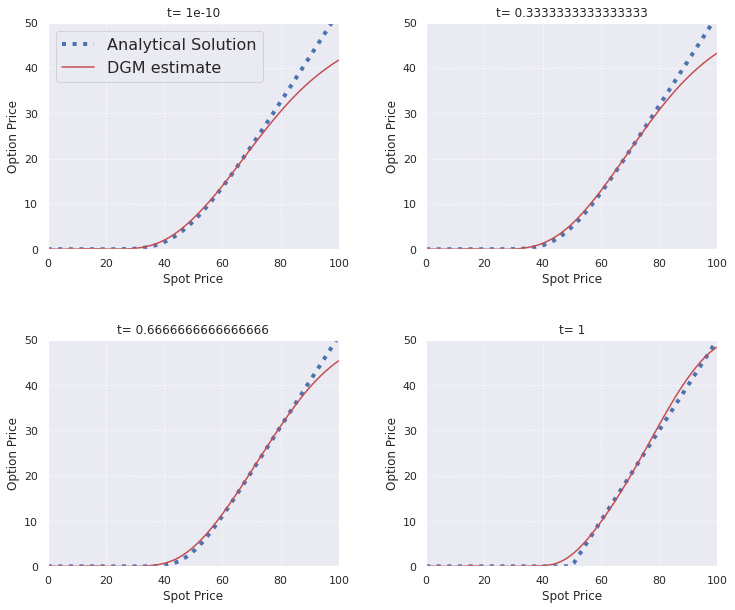

In [ ]:
#%% Plot results

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)


for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(S_plot, optionValue, color = 'b', label='Analytical Solution', linewidth = 4, linestyle=':')
    plt.plot(S_plot, fitted_optionValue[0], color = 'r', label='DGM estimate')    
    
    # subplot options
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel(r"Spot Price")
    plt.ylabel("Option Price")
    plt.title("t= "+ str(curr_t))
    plt.xticks()
    plt.yticks()
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 16})
    
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

#### normal

In [ ]:
RMSE_i,RMSE_f,sup_i,sup_f = error_train()

L2
37.65060514831126
19.97045184823426
L inf
622.2364359903945 punto : [119.80467874] [0.00498115]
360.4411789720887 punto : [119.98350321] 1


In [ ]:
RMSE_i_test,RMSE_f_test,sup_i_test,sup_f_test,error_matrix = error_test()

L2
3.1642942697488725
0.7117277363417408
L inf
114.33758028562805 punto : 100.0 1e-10
6.478853551615342 punto : 50.02000800325126 1


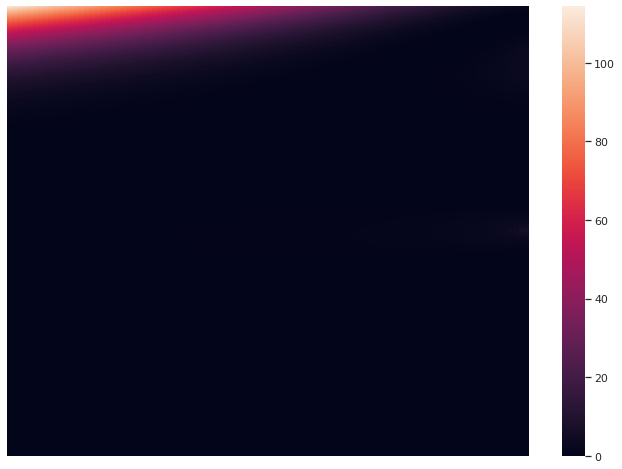

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(error_matrix, yticklabels=False, xticklabels=False)

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)


fig = go.Figure()
fig.add_trace(go.Box(y=RMSE_i,name=" train Interior"))
fig.add_trace(go.Box(y=RMSE_f, name= "train frontera"))
fig.add_trace(go.Box(y=RMSE_i_test,name=" test Interior"))
fig.add_trace(go.Box(y=[RMSE_f_test], name= "test frontera"))

fig.show()

#### otra arquitectura

In [ ]:
# time values at which to examine density

RMSE_i=[] #interior
sup_i=0
RMSE_f=[] #frontera
sup_f=0
for epoch in range(len(X_train)):
  #dominio
  optionValue = BlackScholesCall(X_train[epoch][1], K, r, sigma, X_train[epoch][0])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_i_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  optionValue = BlackScholesCall(X_train[epoch][3], K, r, sigma, X_train[epoch][2])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_f.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_f_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
print("L2")
print(np.mean(RMSE_i))
print(np.mean(RMSE_f))
print("L inf")
print(sup_i)
print(sup_f)


L2
35.064098652913216
18.232481336069338
L inf
23.285898315032327
17.362174425078607


considerando el aumento progresivo

In [ ]:
# time values at which to examine density

RMSE_i=0 #interior
sup_i=0
RMSE_f=0 #frontera
sup_f=0
for epoch in range(len(X_train)):
  #dominio
  optionValue = BlackScholesCall(X_train[epoch][1], K, r, sigma, X_train[epoch][0])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_i_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  optionValue = BlackScholesCall(X_train[epoch][3], K, r, sigma, X_train[epoch][2])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_f+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_f_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
print("L2")
print(RMSE_i/len(X_train))
print(RMSE_f/len(X_train))
print("L inf")
print(sup_i)
print(sup_f)


L2
6.579990120017323
0.13770326250307624
L inf
14.18693893457214
2.7658980851856967


ir a buscar el L infinito

error de test

In [ ]:
# time values at which to examine density
n_eval= int(nSim_interior*len(X_train)*0.1) #10% test
n_eval_t= 100
valueTimes=np.linspace(t_low, T, n_eval_t)

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_eval)

#RMSE

RMSE_i=[] #interior
sup_i=0
sup_i_l=[]


for curr_t in valueTimes:

# simulate process at current t 
  optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
  t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
  RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_i_=np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  sup_i_l.append(sup_i_)
  if sup_i<sup_i_:
    sup_i= sup_i_

#frontera

optionValue = BlackScholesCall(S_plot, K, r, sigma, T)
  
t_plot = T * np.ones_like(S_plot.reshape(-1,1))
fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
RMSE_f= mean_squared_error(optionValue, fitted_optionValue[0])
sup_f= np.max(abs(np.array(list(optionValue))-np.array(list(fitted_optionValue[0]))))


print("L2")
print(np.mean(RMSE_i) )
print(RMSE_f)
print("L inf")
print(sup_i)
print(sup_f)


L2
0.47668719502114115
0.03814925254079068
L inf
52.47566730272546
50.49720764160156


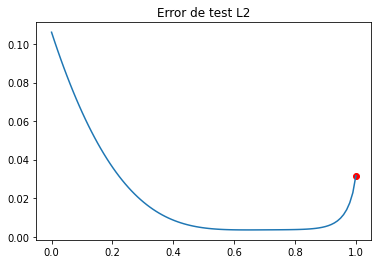

In [ ]:
plt.plot(valueTimes,RMSE_i )
plt.scatter(1,RMSE_f, color= "red")
plt.title("Error de test L2")
plt.show()

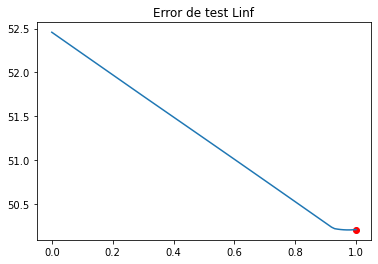

In [ ]:
plt.plot(valueTimes,sup_i_l )
plt.scatter(1,sup_f, color= "red")
plt.title("Error de test Linf")
plt.show()

sin coeficiente de expansion, es mejor en train pero en test es mejor con expansion pero el maximo error es invariante

por alguna razon considerar mas dominio le permite generalizar mejor

considerando el aumento progresivo

In [ ]:
# time values at which to examine density

RMSE_i=0 #interior
sup_i=0
RMSE_f=0 #frontera
sup_f=0
for epoch in range(len(X_train)):
  #dominio
  optionValue = BlackScholesCall(X_train[epoch][1], K, r, sigma, X_train[epoch][0])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_i_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  optionValue = BlackScholesCall(X_train[epoch][3], K, r, sigma, X_train[epoch][2])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_i+=mean_squared_error(optionValue, fitted_optionValue[0])
  RMSE_f+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_f_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
print("L2")
print(RMSE_i/len(X_train))
print(RMSE_f/len(X_train))
print("L inf")
print(sup_i)
print(sup_f)

L2
5.443028544265042
0.5867877858707553
L inf
11.71022283854559
4.3142300581988025


In [ ]:
# time values at which to examine density
n_eval= int(nSim_interior*len(X_train)*0.1) #10% test
n_eval_t= 100
valueTimes=np.linspace(t_low, T, n_eval_t)

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_eval)

#RMSE

RMSE_i=[] #interior
sup_i=0
sup_i_l=[]


for curr_t in valueTimes:

# simulate process at current t 
  optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
  t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
  RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_i_=np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  sup_i_l.append(sup_i_)
  if sup_i<sup_i_:
    sup_i= sup_i_

#frontera

optionValue = BlackScholesCall(S_plot, K, r, sigma, T)
  
t_plot = T * np.ones_like(S_plot.reshape(-1,1))
fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
RMSE_f= mean_squared_error(optionValue, fitted_optionValue[0])
sup_f= np.max(abs(np.array(list(optionValue))-np.array(list(fitted_optionValue[0]))))


print("L2")
print(np.mean(RMSE_i) )
print(RMSE_f)
print("L inf")
print(sup_i)
print(sup_f)

L2
5.014358998217724
0.6100771829530443
L inf
52.47383463871255
50.37074416875839


RMSE en tiempo= RMSEt(error tipo interpolación (test) para una completación uniforme con un grado de magnitud mayor al entrenamiento) sin multiplicador es 16.6428, si consideramos un facor de multiplicación 1.5 que expande el dominio el RMSEt es 1.2069 - 0.9451 (requiere confianza)

RMSE en tiempo cuando considere la misma cantidad de minibatch (sampleos) pero 40 en vez de 10 epocas por sampleo el error es de 0.018, con un lambda de 0.1 dio 0.034

RMSE en tiempo cuando corro 510 veces (equivalente en entrenamiento a hacer 50 sampleos y 10 iteraciones) para un sample fijo, es 8.3644

¿por que es una ventaja tener más datos? ¿pasa algo en la frontera?

#### adaptativo

<Figure size 842.4x595.44 with 0 Axes>

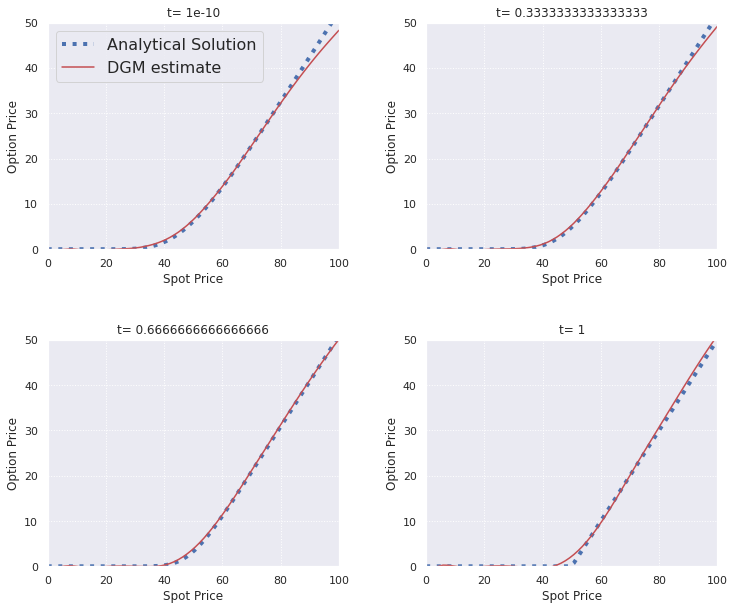

In [ ]:
#%% Plot results

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)


for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(S_plot, optionValue, color = 'b', label='Analytical Solution', linewidth = 4, linestyle=':')
    plt.plot(S_plot, fitted_optionValue[0], color = 'r', label='DGM estimate')    
    
    # subplot options
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel(r"Spot Price")
    plt.ylabel("Option Price")
    plt.title("t= "+ str(curr_t))
    plt.xticks()
    plt.yticks()
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 16})
    
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

In [ ]:
RMSE_i,RMSE_f,sup_i,sup_f = error_train()

L2
0.7291481430717269
1.710452365495282
L inf
124.31453960729587 punto : [119.89447193] [0.06078379]
40.729702817239755 punto : [119.98350321] 1


In [ ]:
RMSE_i_test,RMSE_f_test,sup_i_test,sup_f_test,error_matrix = error_test()

L2
0.3226921914353054
0.45223150198252826
L inf
17.129081032911838 punto : 100.0 1e-10
4.8750272364447875 punto : 50.02000800325126 1


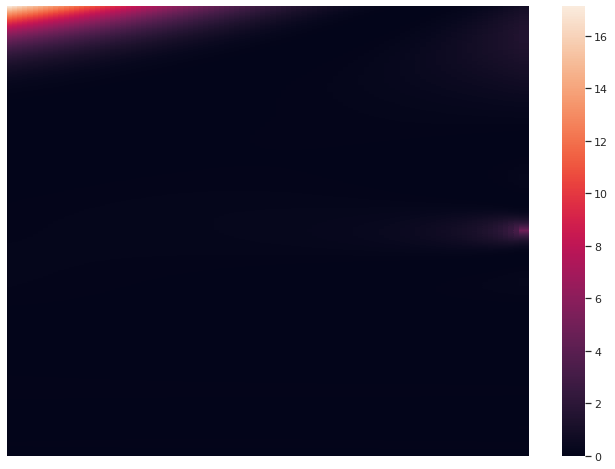

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(error_matrix, yticklabels=False, xticklabels=False)

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)


fig = go.Figure()
fig.add_trace(go.Box(y=RMSE_i,name=" train Interior"))
fig.add_trace(go.Box(y=RMSE_f, name= "train frontera"))
fig.add_trace(go.Box(y=RMSE_i_test,name=" test Interior"))
fig.add_trace(go.Box(y=[RMSE_f_test], name= "test frontera"))

fig.show()

#### de lo general a lo particular

train

In [ ]:
# time values at which to examine density

RMSE_i=0 #interior
sup_i=0
RMSE_f=0 #frontera
sup_f=0
for epoch in range(len(X_train)):
  #dominio
  optionValue = BlackScholesCall(X_train[epoch][1], K, r, sigma, X_train[epoch][0])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][0], S_interior_tnsr:X_train[epoch][1]})
  RMSE_i+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_i_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_i<sup_i_:
    sup_i= sup_i_

  #frontera
  optionValue = BlackScholesCall(X_train[epoch][3], K, r, sigma, X_train[epoch][2])
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr: X_train[epoch][2], S_interior_tnsr:X_train[epoch][3]})
  RMSE_f+=mean_squared_error(optionValue, fitted_optionValue[0])
  sup_f_= np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  if sup_f<sup_f_:
    sup_f= sup_f_
print("L2")
print(RMSE_i/len(X_train))
print(RMSE_f/len(X_train))
print("L inf")
print(sup_i)
print(sup_f)


L2
91.13999690909787
0.19912835935022194
L inf
14.003908635943887
3.1611579312987033


test

In [ ]:
# time values at which to examine density
n_eval= int(nSim_interior*len(X_train)*0.1) #10% test
n_eval_t= 100
valueTimes=np.linspace(t_low, T, n_eval_t)

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_eval)

#RMSE

RMSE_i=[] #interior
sup_i=0
sup_i_l=[]


for curr_t in valueTimes:

# simulate process at current t 
  optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
  t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
  RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_i_=np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  sup_i_l.append(sup_i_)
  if sup_i<sup_i_:
    sup_i= sup_i_

#frontera

optionValue = BlackScholesCall(S_plot, K, r, sigma, T)
  
t_plot = T * np.ones_like(S_plot.reshape(-1,1))
fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
RMSE_f= mean_squared_error(optionValue, fitted_optionValue[0])
sup_f= np.max(abs(np.array(list(optionValue))-np.array(list(fitted_optionValue[0]))))

print("L2")
print("Interior: ", np.mean(RMSE_i) )
print("Frontera: ", RMSE_f)
print("L inf")
print("Interior: ",sup_i)
print("Frontera: ", sup_f)

L2
Interior:  0.4904629856044476
Frontera:  0.029362640498034637
L inf
Interior:  52.48496723663583
Frontera:  50.24397563934326


lo anterior con 1.2, ahora con 1.0 sin extender la frontera

#### concentrado

In [ ]:
# time values at which to examine density
n_eval= int(nSim_interior*len(X_train)*0.1) #10% test
n_eval_t= 100
valueTimes=np.linspace(t_low, T, n_eval_t)

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_eval)

#RMSE

RMSE_i=[] #interior
sup_i=0
sup_i_l=[]


for curr_t in valueTimes:

# simulate process at current t 
  optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
  t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
  fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
  RMSE_i.append(mean_squared_error(optionValue, fitted_optionValue[0]))
  sup_i_=np.max(abs(np.array(optionValue)-np.array(fitted_optionValue[0])))
  sup_i_l.append(sup_i_)
  if sup_i<sup_i_:
    sup_i= sup_i_

#frontera

optionValue = BlackScholesCall(S_plot, K, r, sigma, T)
  
t_plot = T * np.ones_like(S_plot.reshape(-1,1))
fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
RMSE_f= mean_squared_error(optionValue, fitted_optionValue[0])
sup_f= np.max(abs(np.array(list(optionValue))-np.array(list(fitted_optionValue[0]))))

print("L2")
print("Interior: ", np.mean(RMSE_i) )
print("Frontera: ", RMSE_f)
print("L inf")
print("Interior: ",sup_i)
print("Frontera: ", sup_f)

L2
Interior:  0.2433290057807492
Frontera:  0.11513445516419964
L inf
Interior:  52.55192524683252
Frontera:  50.53327941894531


X -> y_n -> y= \Sum wi y_n

SGD min la loss L(y) 


gradient boosting





# Black Scholes 100D

codigo: https://github.com/maziarraissi/FBSNNs

## Arquitectura

In [ ]:

import numpy as np
#import tensorflow as tf
import time
from abc import ABC, abstractmethod

class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi, T,
                       M, N, D,
                       layers):
        
        self.Xi = Xi # initial point
        self.T = T # terminal time
        
        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions
        
        # layers
        self.layers = layers # (D+1) --> 1
        
        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf session
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # tf placeholders and graph (training)
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.compat.v1.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        self.Xi_tf = tf.compat.v1.placeholder(tf.float32, shape=[1, D]) # 1 x D

        self.loss, self.X_pred, self.Y_pred, self.Y0_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)
                
        # optimizers
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
        # initialize session and variables
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
    
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, t, X): # M x 1, M x D
        
        u = self.neural_net(tf.concat([t,X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(ys=u, xs=X)[0] # M x D
        
        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(ys=self.g_tf(X), xs=X)[0] # M x D
        
    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = 0
        X_list = []
        Y_list = []
        
        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D
        
        X_list.append(X0)
        Y_list.append(Y0)
        
        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(input_tensor=Z0*tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
            Y1, Z1 = self.net_u(t1,X1)
            
            loss += tf.reduce_sum(input_tensor=tf.square(Y1 - Y1_tilde))
            
            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            
            X_list.append(X0)
            Y_list.append(Y0)
            
        loss += tf.reduce_sum(input_tensor=tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(input_tensor=tf.square(Z1 - self.Dg_tf(X1)))

        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)
        
        return loss, X, Y, Y[0,0,0]

    def fetch_minibatch(self):
        T = self.T
        
        M = self.M
        N = self.N
        D = self.D
        
        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D
        
        dt = T/N
        
        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))
        
        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D
        
        return t, W
    
    def train(self, N_Iter, learning_rate):
        
        start_time = time.time()
        for it in range(N_Iter):
            
            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D
            
            tf_dict = {self.Xi_tf: self.Xi, self.t_tf: t_batch, self.W_tf: W_batch, self.learning_rate: learning_rate}
            
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Learning Rate: %.3e' % 
                      (it, loss_value, Y0_value, elapsed, learning_rate_value))
                start_time = time.time()
                
    
    def predict(self, Xi_star, t_star, W_star):
        
        tf_dict = {self.Xi_tf: Xi_star, self.t_tf: t_star, self.W_tf: W_star}
        
        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        
        return X_star, Y_star
    
    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1
    
    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1
    
    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D
    
    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.linalg.diag(tf.ones([M,D])) # M x D x D
    ###########################################################################

In [ ]:
"""
@author: Maziar Raissi
"""

import numpy as np
#import tensorflow as tf
#from FBSNNs import FBSNN
import matplotlib.pyplot as plt
#from plotting import newfig, savefig

class BlackScholesBarenblatt(FBSNN):
    def __init__(self, Xi, T,
                       M, N, D,
                       layers):
        
        super().__init__(Xi, T,
                         M, N, D,
                         layers)
               
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return 0.05*(Y - tf.reduce_sum(input_tensor=X*Z, axis=1, keepdims = True)) # M x 1
    
    def g_tf(self, X): # M x D
        return tf.reduce_sum(input_tensor=X**2, axis=1, keepdims = True) # M x 1

    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return super().mu_tf(t, X, Y, Z) # M x D
        
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X) # M x D x D
    
    ###########################################################################

if __name__ == "__main__":
    
    M = 60 # number of trajectories (batch size)
    N = 50 # number of time snapshots
    D = 100 # number of dimensions
    
    layers = [D+1] + 4*[256] + [1]

    Xi = np.array([1.0,0.5]*int(D/2))[None,:]
    T = 1.0
         
    # Training
    model = BlackScholesBarenblatt(Xi, T,
                                   M, N, D,
                                   layers)
    
    model.train(N_Iter = 5000, learning_rate=1e-3)
   # model.train(N_Iter = 2*10**4, learning_rate=1e-3)
    
    #model.train(N_Iter = 3*10**4, learning_rate=1e-4)
    #model.train(N_Iter = 3*10**4, learning_rate=1e-5)
    #model.train(N_Iter = 2*10**4, learning_rate=1e-6)
    

    
    # savefig('./figures/BSB_Apr18_50_errors', crop = False)

Device mapping: no known devices.
It: 0, Loss: 3.192e+05, Y0: 3.249, Time: 9.20, Learning Rate: 1.000e-03
It: 10, Loss: 2.362e+05, Y0: 15.973, Time: 5.76, Learning Rate: 1.000e-03
It: 20, Loss: 2.053e+05, Y0: 18.729, Time: 5.75, Learning Rate: 1.000e-03
It: 30, Loss: 1.693e+05, Y0: 21.465, Time: 6.76, Learning Rate: 1.000e-03
It: 40, Loss: 1.658e+05, Y0: 24.091, Time: 5.76, Learning Rate: 1.000e-03
It: 50, Loss: 1.503e+05, Y0: 26.651, Time: 5.87, Learning Rate: 1.000e-03
It: 60, Loss: 1.367e+05, Y0: 29.106, Time: 5.77, Learning Rate: 1.000e-03
It: 70, Loss: 1.278e+05, Y0: 31.462, Time: 5.83, Learning Rate: 1.000e-03
It: 80, Loss: 1.172e+05, Y0: 33.647, Time: 5.72, Learning Rate: 1.000e-03
It: 90, Loss: 1.058e+05, Y0: 35.952, Time: 5.68, Learning Rate: 1.000e-03
It: 100, Loss: 9.668e+04, Y0: 37.938, Time: 5.82, Learning Rate: 1.000e-03
It: 110, Loss: 8.113e+04, Y0: 40.219, Time: 5.83, Learning Rate: 1.000e-03
It: 120, Loss: 7.547e+04, Y0: 42.183, Time: 5.82, Learning Rate: 1.000e-03
It:

In [ ]:

if __name__ == "__main__":
    ##### PLOT RESULTS
    
    t_test, W_test = model.fetch_minibatch()
    
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
        
    def u_exact(t, X): # (N+1) x 1, (N+1) x D
        r = 0.05
        sigma_max = 0.4
        return np.exp((r + sigma_max**2)*(T - t))*np.sum(X**2, 1, keepdims = True) # (N+1) x 1
        
    Y_test = np.reshape(u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])),[M,-1,1])
    
    samples = 5
    
    
    # savefig('./figures/BSB_Apr18_50', crop = False)
    
    


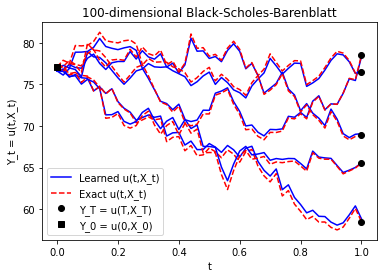

In [ ]:
  
plt.figure()
plt.plot(t_test[0:1,:,0].T,Y_pred[0:1,:,0].T,'b',label='Learned u(t,X_t)')
plt.plot(t_test[0:1,:,0].T,Y_test[0:1,:,0].T,'r--',label='Exact u(t,X_t)')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='Y_T = u(T,X_T)')
    
plt.plot(t_test[1:samples,:,0].T,Y_pred[1:samples,:,0].T,'b')
plt.plot(t_test[1:samples,:,0].T,Y_test[1:samples,:,0].T,'r--')
plt.plot(t_test[1:samples,-1,0],Y_test[1:samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='Y_0 = u(0,X_0)')
    
plt.xlabel('t')
plt.ylabel('Y_t = u(t,X_t)')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()
plt.show()

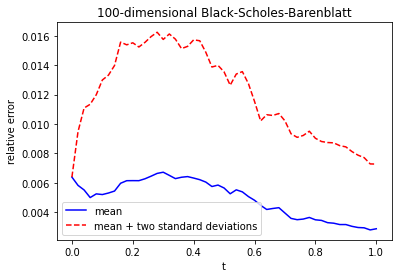

In [ ]:
errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)
mean_errors = np.mean(errors,0)
std_errors = np.std(errors,0)
    
plt.figure()
plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
plt.xlabel('t')
plt.ylabel('relative error')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

In [ ]:
t_test, W_test = model.fetch_minibatch()
    
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

In [ ]:
t_test.shape

(100, 51, 1)

In [ ]:
W_test.shape

(100, 51, 100)

In [ ]:
X_pred.shape

(60, 51, 100)

In [ ]:
Y_pred.shape

(100, 51, 1)

La edp depende de un proceso estocastico en alta dimensionalidad $X_t$ que se logra aproximar apartir de un metodo de euler y red 5ff, metodo el cual tambien aproxima la solución $Y_t= u(t,X_t)$ solucion analitica de la edp, esto lo hace apartir de realizaciones aleatorias normales de $W_t$ y una partición del tiempo

Podría:

Utilizar el X predicho y DGM, se mejora el Y predicho?

Utilizar un X aleatorio y DGM




aca la forma cartesiana pag (25)

https://arxiv.org/pdf/1709.05963.pdf